# EDA Structured Database

En este notebook se realizó el análisis final de las sociedades consitutidas con el conjunto de datos normalizado.

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine
from dotenv import load_dotenv

In [3]:
load_dotenv()

DB_USER = os.getenv("MYSQL_USER")
DB_PASSWORD = os.getenv("MYSQL_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_NAME = os.getenv("MYSQL_DATABASE")

DATABASE_URL = f"mysql+mysqlconnector://{DB_USER}:{DB_PASSWORD}@{DB_HOST}/{DB_NAME}"

engine = create_engine(DATABASE_URL)
connection = engine.connect()

 ## 1. Carga de Datos

Realizamos las consultas SQL para traer los datos a DataFrames de Pandas. Limitamos las columnas a las necesarias para optimizar la memoria.


In [4]:
# Consultas SQL para extraer los datos
query_sociedades = """
SELECT *
FROM sociedades
"""

query_socios = """
SELECT *
FROM socios
"""

query_directorio = """
SELECT *
FROM directorio
"""

print("Cargando datos desde la base de datos...")

# Cargamos los DataFrames
df_sociedades = pd.read_sql(query_sociedades, connection)
df_socios = pd.read_sql(query_socios, connection)
df_directorio = pd.read_sql(query_directorio, connection)

print(f"Sociedades cargadas: {df_sociedades.shape}")
print(f"Socios cargados: {df_socios.shape}")
print(f"Directorio cargado: {df_directorio.shape}")



Cargando datos desde la base de datos...
Sociedades cargadas: (65291, 12)
Socios cargados: (150295, 13)
Directorio cargado: (140327, 4)


In [5]:
print(df_sociedades.head())

   id                       nombre  \
0   1  TECNOLOGIA Y CABLEADOS S.A.   
1   2      BOMBAS DE HORMIGON S.A.   
2   3                   Bhrisa SA.   
3   4                       BELFIL   
4   5                 GRUPO SAMIRA   

                                    sede_social fecha_inicio  \
0         Cuenca 4932 piso 7 Depto. A Cap. Fed.   2010-12-21   
1  Alvarez Thomas 195 piso 2 Depto, B Cap. Fed.   2010-12-16   
2                   Gallo 943, Piso 16 "B" CABA   2010-12-21   
3       Avenida del Libertador 4626 piso 3 CABA   2010-12-21   
4       Tacuarí 1095 Piso 4º Oficina A C.A.B.A.         None   

                     duracion  \
0                     99 años   
1                     99 años   
2  99 años desde inscripción.   
3                     99 años   
4                     99 años   

                                              objeto  capital_social  \
0  ["Compraventa, locación, importación, exportac...         12000.0   
1  ["Compra, venta, locación, importación, 

In [6]:
print(df_socios.head())

   id  sociedad_id         dni cuit_cuil    profesion  \
0   1            1   4.448.348            comerciante   
1   2            1  25.786.418               empleado   
2   3            2  16.134.074             Empresario   
3   4            2  26.877.454             Empresario   
4   5            2  23.704.541             Empresario   

                                           domicilio  \
0              Olivera 2395 Ituzaingo, Pcia. Bs. As.   
1              Cuenca 4932 piso 7 Depto. A Cap. Fed.   
2  Calle 190 número 1781, José Leon Suárez, Pcia....   
3             Ramón Castro 4170, Munro, Pcia Bs. As.   
4  Diagonal 69 número 6992 José Leon Suárez, Pcia...   

                             sede_social estado_civil nacionalidad  \
0  Olivera 2395 Ituzaingo, Pcia. Bs. As.       casado    argentino   
1  Cuenca 4932 piso 7 Depto. A Cap. Fed.       casado    argentino   
2                                              Casado    Argentino   
3                                       

In [7]:
print(df_directorio.head())

   id  sociedad_id                nombre_completo              cargo
0   1            1           Carlos Alberto Kogan         Presidente
1   2            1  Walter Carlos Antonio Fabrica  Director Suplente
2   3            2                 Rodolfo Gontek         Presidente
3   4            2    Leonardo Guillermo Graviano  Director Suplente
4   5            3       Sebastián Andrés Patrone         Presidente


## 2. Limpieza y Preprocesamiento
Antes de visualizar, necesitamos asegurar que los tipos de datos sean correctos, especialmente las fechas y números.



In [8]:
# --- Limpieza de Sociedades ---
# Convertir fecha a datetime y extraer año
df_sociedades['fecha_inicio'] = pd.to_datetime(df_sociedades['fecha_inicio'], errors='coerce')
df_sociedades['anio_inicio'] = df_sociedades['fecha_inicio'].dt.year

# Limpieza básica de Capital Social (reemplazar nulos con 0 para visualización)
df_sociedades['capital_social'] = pd.to_numeric(df_sociedades['capital_social'], errors='coerce').fillna(0)

# Eliminamos las sociedades con fecha de inicio incorrecta
df_sociedades = df_sociedades[df_sociedades['fecha_inicio'] >= pd.Timestamp("2010-01-01")]

In [9]:
# --- Limpieza de Socios ---
# Convertir fecha de nacimiento
df_socios['fecha_nacimiento'] = pd.to_datetime(df_socios['fecha_nacimiento'], errors='coerce')

# Filtramos fechas corruptas o demasiado antiguas que causan OverflowError
# Pandas maneja fechas desde 1677, pero para evitar errores matemáticos y lógicos, filtramos desde 1900
df_socios = df_socios[df_socios['fecha_nacimiento'] >= pd.Timestamp("1900-01-01")]

# Calcular edad aproximada si no existiera (asumiendo fecha actual 2024)
# Si el campo 'edad' ya viene limpio de la DB, podemos omitir esto, pero es útil recalcular para validar.
now = pd.Timestamp.now()
df_socios['edad_calculada'] = (now - df_socios['fecha_nacimiento']).dt.days // 365

# Filtrar edades imposibles (ej: < 18 o > 100 para limpieza de ruido)
df_socios = df_socios[(df_socios['edad_calculada'] > 18) & (df_socios['edad_calculada'] < 100)]

print("Preprocesamiento completado.")
df_sociedades.info()

Preprocesamiento completado.
<class 'pandas.core.frame.DataFrame'>
Index: 64739 entries, 0 to 65290
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 64739 non-null  int64         
 1   nombre             64739 non-null  object        
 2   sede_social        64739 non-null  object        
 3   fecha_inicio       64739 non-null  datetime64[ns]
 4   duracion           64739 non-null  object        
 5   objeto             7858 non-null   object        
 6   capital_social     64739 non-null  float64       
 7   valor_por_accion   64739 non-null  float64       
 8   cantidad_acciones  64739 non-null  int64         
 9   aviso_id           64553 non-null  object        
 10  clase_objeto       64553 non-null  object        
 11  id_direccion       0 non-null      object        
 12  anio_inicio        64739 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int

In [10]:
df_socios.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138208 entries, 0 to 150294
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 138208 non-null  int64         
 1   sociedad_id        138208 non-null  int64         
 2   dni                138208 non-null  object        
 3   cuit_cuil          138208 non-null  object        
 4   profesion          138208 non-null  object        
 5   domicilio          138208 non-null  object        
 6   sede_social        360 non-null     object        
 7   estado_civil       138208 non-null  object        
 8   nacionalidad       138208 non-null  object        
 9   nombre_completo    138208 non-null  object        
 10  fecha_nacimiento   138208 non-null  datetime64[ns]
 11  cantidad_acciones  138208 non-null  int64         
 12  id_direccion       0 non-null       object        
 13  edad_calculada     138208 non-null  int64        

## 3. Análisis Temporal: Creación de Sociedades
¿Cómo ha evolucionado la creación de empresas a lo largo del tiempo?
Este gráfico nos permite ver picos de actividad económica o registro.


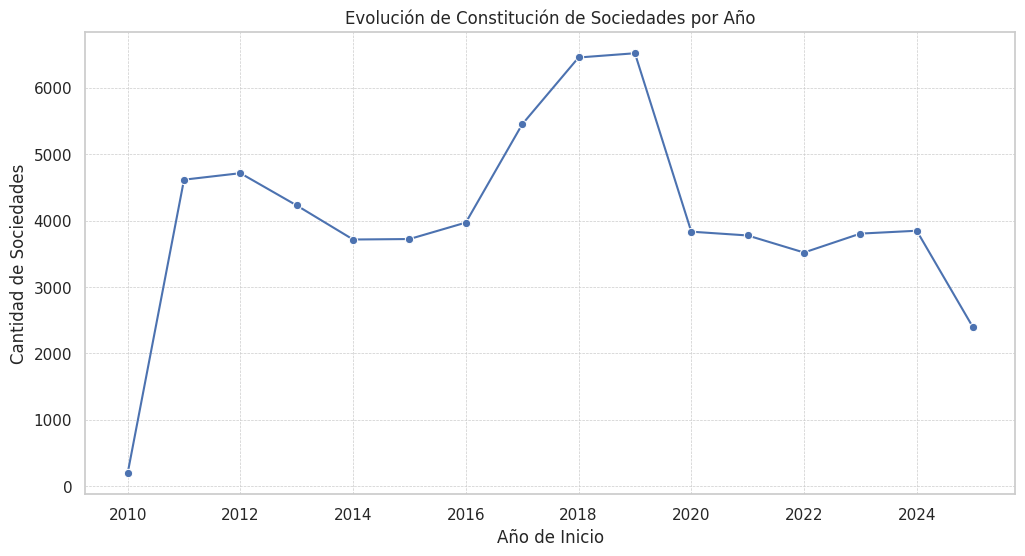

In [11]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

# Filtramos años con sentido (ej: mayores a 1950 y menores a fecha actual futura)
sociedades_por_anio = df_sociedades[
    (df_sociedades['anio_inicio'] > 1950) & 
    (df_sociedades['anio_inicio'] <= pd.Timestamp.now().year)
]['anio_inicio'].value_counts().sort_index()

sns.lineplot(x=sociedades_por_anio.index, y=sociedades_por_anio.values, marker="o", color="b")

plt.title('Evolución de Constitución de Sociedades por Año')
plt.xlabel('Año de Inicio')
plt.ylabel('Cantidad de Sociedades')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

**Interpretación:** Muestra un pico masivo de creación de empresas entre 2017 y 2019.

**Insight:** Este comportamiento suele coincidir con la ley de SAS (Sociedades por Acciones Simplificadas) en Argentina (2017), que facilitó la creación digital de empresas en 24 horas. La caída posterior coincide con el cambio de gestión política y la pandemia.

## 4. Análisis Financiero: Capital Social
Analizamos la distribución del capital social. Dado que los montos pueden variar exponencialmente, utilizaremos una escala logarítmica para visualizar mejor la distribución.

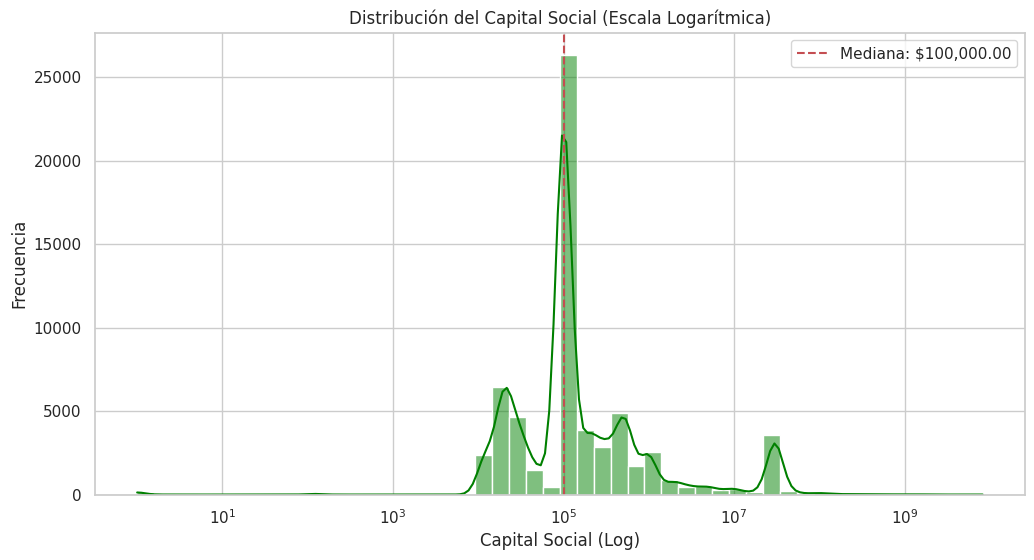

In [12]:
plt.figure(figsize=(12, 6))

# Filtramos capitales > 0 para evitar errores en logaritmo
capital_data = df_sociedades[df_sociedades['capital_social'] > 0]['capital_social']

sns.histplot(capital_data, bins=50, log_scale=True, color="green", kde=True)

plt.title('Distribución del Capital Social (Escala Logarítmica)')
plt.xlabel('Capital Social (Log)')
plt.ylabel('Frecuencia')
plt.axvline(capital_data.median(), color='r', linestyle='--', label=f'Mediana: ${capital_data.median():,.2f}')
plt.legend()
plt.show()

**Interpretación:** Es una distribución multimodal (tiene varios "picos").

**Insight:** Los picos no son aleatorios; representan los montos mínimos legales para constituir sociedades en diferentes épocas (ej. $12.000, $100.000). La escala logarítmica permite ver sociedades pequeñas y grandes corporaciones en el mismo gráfico.

## 5. Análisis del Objeto Social
¿Cuáles son las clases de objeto (rubros) más comunes en la base de datos?

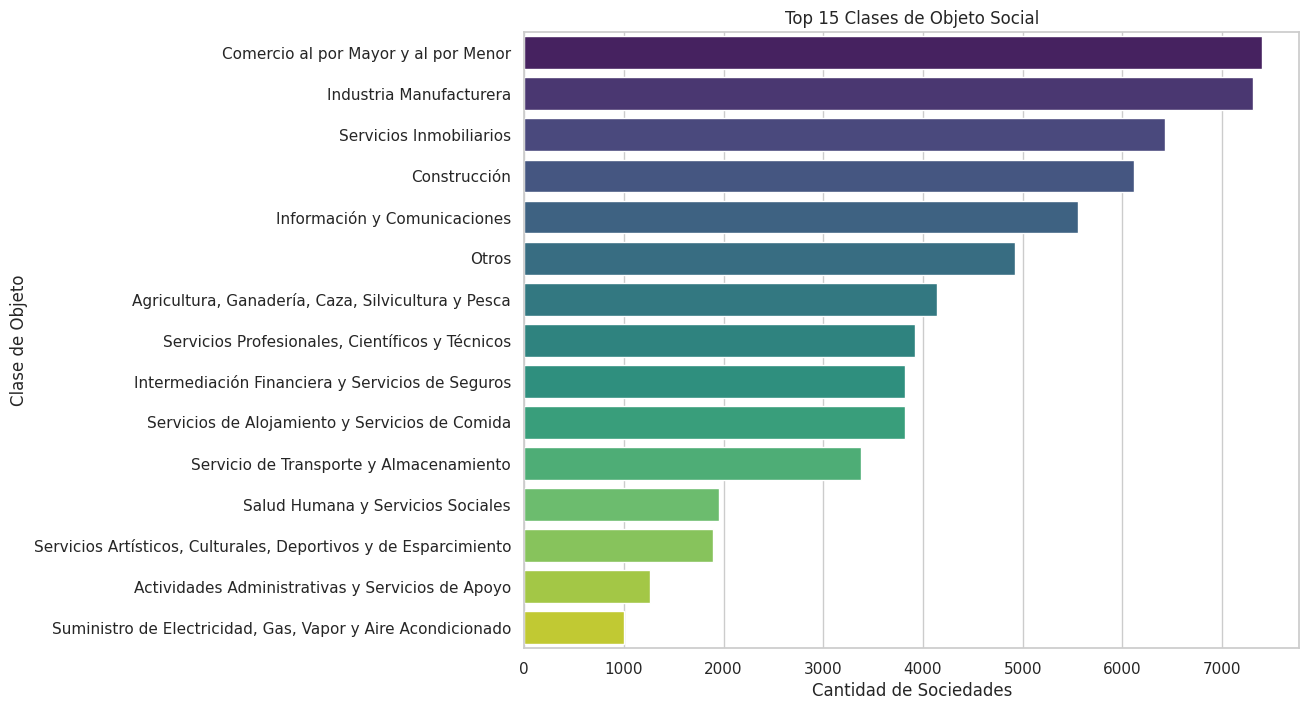

In [13]:
plt.figure(figsize=(10, 8))

# Tomamos el top 15 de clases de objeto
top_objetos = df_sociedades['clase_objeto'].value_counts().head(15)

sns.barplot(y=top_objetos.index, x=top_objetos.values, palette="viridis", hue=top_objetos.index)

plt.title('Top 15 Clases de Objeto Social')
plt.xlabel('Cantidad de Sociedades')
plt.ylabel('Clase de Objeto')
plt.show()

## 6. Perfil de los Socios
Analizamos las características demográficas de las personas físicas que componen las sociedades: Nacionalidad y Edad.


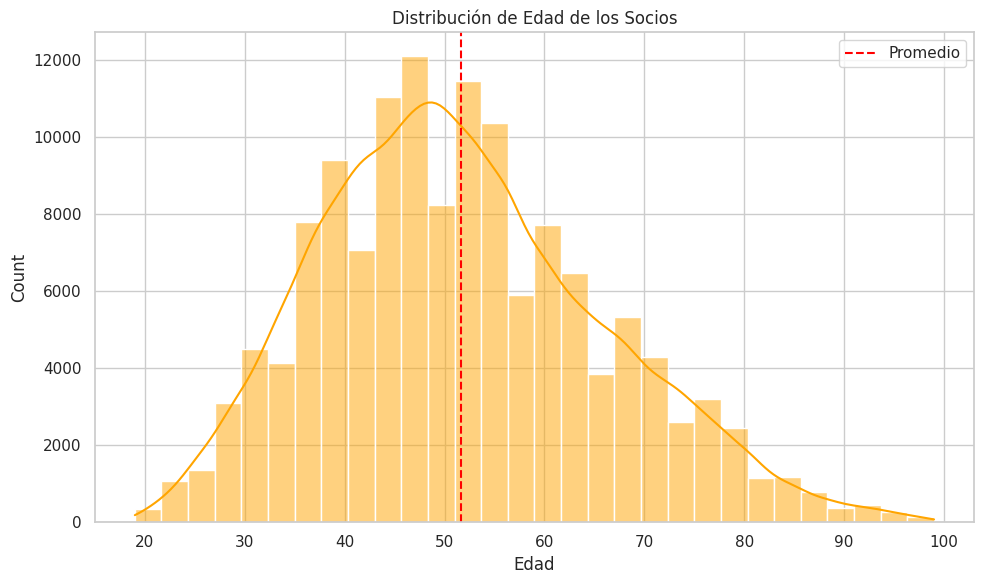

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a single figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# --- Gráfico 2: Distribución de Edad ---
sns.histplot(df_socios['edad_calculada'], bins=30, kde=True, color="orange", ax=ax)

# Set titles and labels on the single axes object 'ax'
ax.set_title('Distribución de Edad de los Socios')
ax.set_xlabel('Edad')

# Add the vertical line for the mean
ax.axvline(df_socios['edad_calculada'].mean(), color='red', linestyle='--', label='Promedio')
ax.legend()

plt.tight_layout()
plt.show()

**Interpretación:** Hay una hegemonía total de socios argentinos. La edad promedio es de 50 años, con una distribución de campana perfecta.

**Insight:** El emprendedurismo formal (constituir sociedad) parece ser una actividad de personas de mediana edad, no de jóvenes de 20 años (quienes quizás operan más como monotributistas o informales).

## 7. Estructura Organizacional
Analizamos la complejidad de las empresas contando cuántos socios y cuántos directores tiene cada una en promedio.


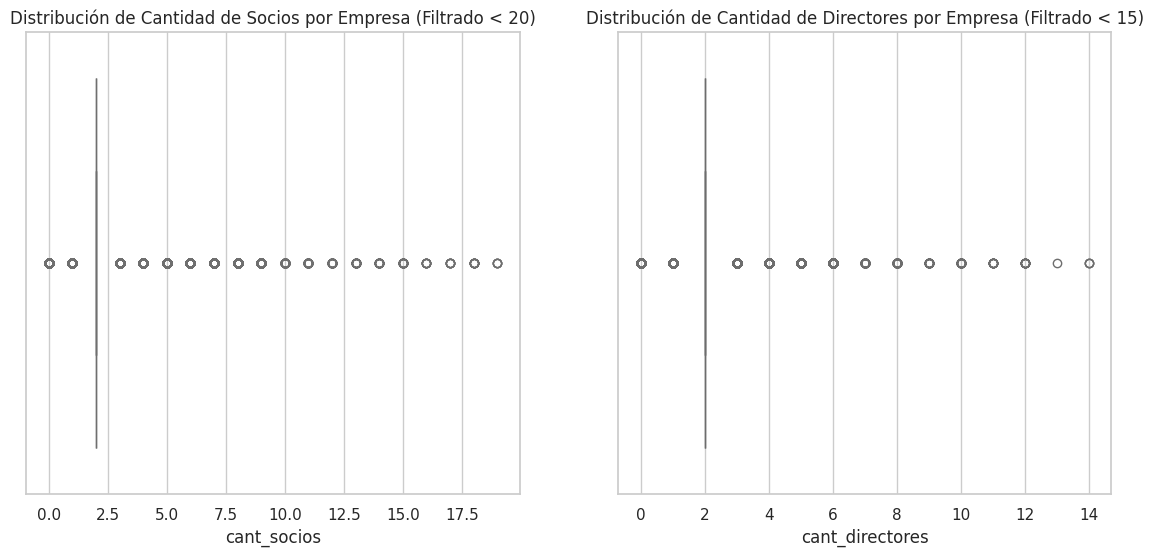

Resumen Estructura Societaria:
        cant_socios  cant_directores
count  64739.000000     64739.000000
mean       2.131405         2.158297
std        1.451754         0.692704
min        0.000000         0.000000
25%        2.000000         2.000000
50%        2.000000         2.000000
75%        2.000000         2.000000
max       43.000000        26.000000


In [15]:
# Agregamos conteos por sociedad
socios_count = df_socios.groupby('sociedad_id').size().reset_index(name='cant_socios')
directorio_count = df_directorio.groupby('sociedad_id').size().reset_index(name='cant_directores')

# Unimos con el dataframe de sociedades
df_estructura = df_sociedades[['id', 'nombre']].merge(socios_count, left_on='id', right_on='sociedad_id', how='left')
df_estructura = df_estructura.merge(directorio_count, left_on='id', right_on='sociedad_id', how='left')

# Rellenamos NaNs con 0 (empresas sin datos de socios/directores cargados)
df_estructura.fillna(0, inplace=True)

# Visualización
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot de cantidad de socios (limitamos outliers extremos para ver mejor la caja)
sns.boxplot(x=df_estructura[df_estructura['cant_socios'] < 20]['cant_socios'], ax=ax[0], color="skyblue")
ax[0].set_title('Distribución de Cantidad de Socios por Empresa (Filtrado < 20)')

# Boxplot de cantidad de directores
sns.boxplot(x=df_estructura[df_estructura['cant_directores'] < 15]['cant_directores'], ax=ax[1], color="salmon")
ax[1].set_title('Distribución de Cantidad de Directores por Empresa (Filtrado < 15)')

plt.show()

# Estadísticas descriptivas breves
print("Resumen Estructura Societaria:")
print(df_estructura[['cant_socios', 'cant_directores']].describe())


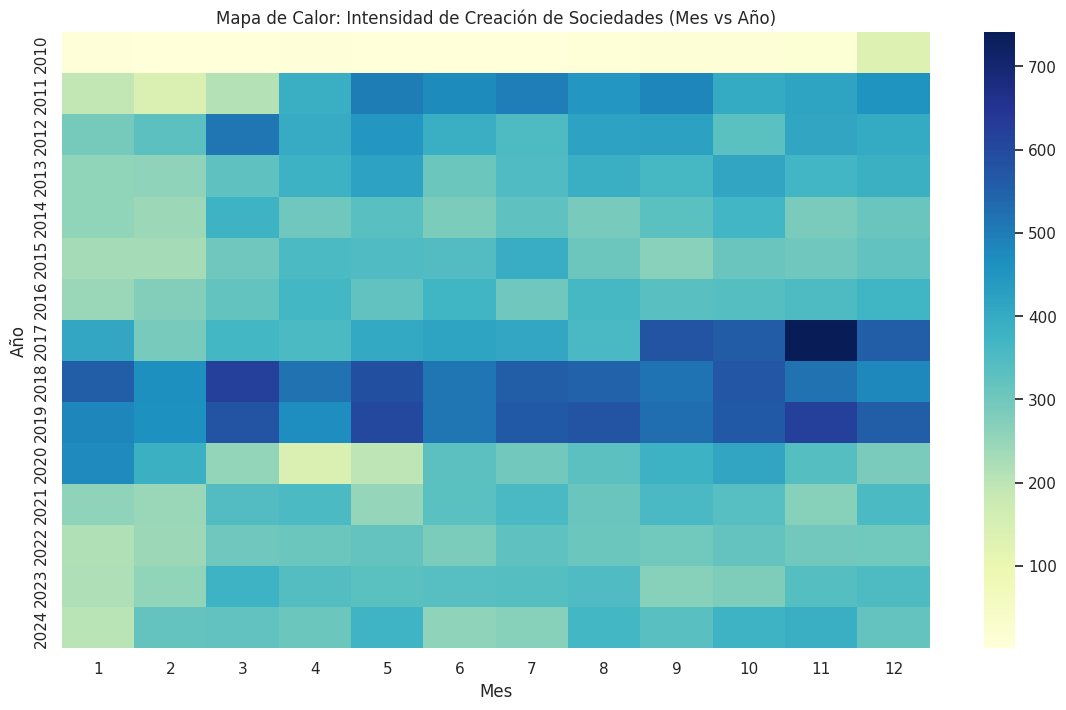

In [16]:
df_sociedades['fecha_inicio'] = pd.to_datetime(df_sociedades['fecha_inicio'], errors='coerce')
df_sociedades['mes'] = df_sociedades['fecha_inicio'].dt.month
df_sociedades['anio'] = df_sociedades['fecha_inicio'].dt.year

# Filtramos años relevantes (ej. 2010 a 2024) para que el gráfico se lea bien
df_heatmap = df_sociedades[(df_sociedades['anio'] >= 2010) & (df_sociedades['anio'] <= 2024)]

# 2. Crear tabla pivote: Años en filas, Meses en columnas
pivot_creacion = df_heatmap.pivot_table(
    index='anio', 
    columns='mes', 
    values='id', 
    aggfunc='count'
).fillna(0)

# 3. Graficar
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_creacion, cmap="YlGnBu", annot=False, fmt='g')
plt.title('Mapa de Calor: Intensidad de Creación de Sociedades (Mes vs Año)')
plt.ylabel('Año')
plt.xlabel('Mes')
plt.show()

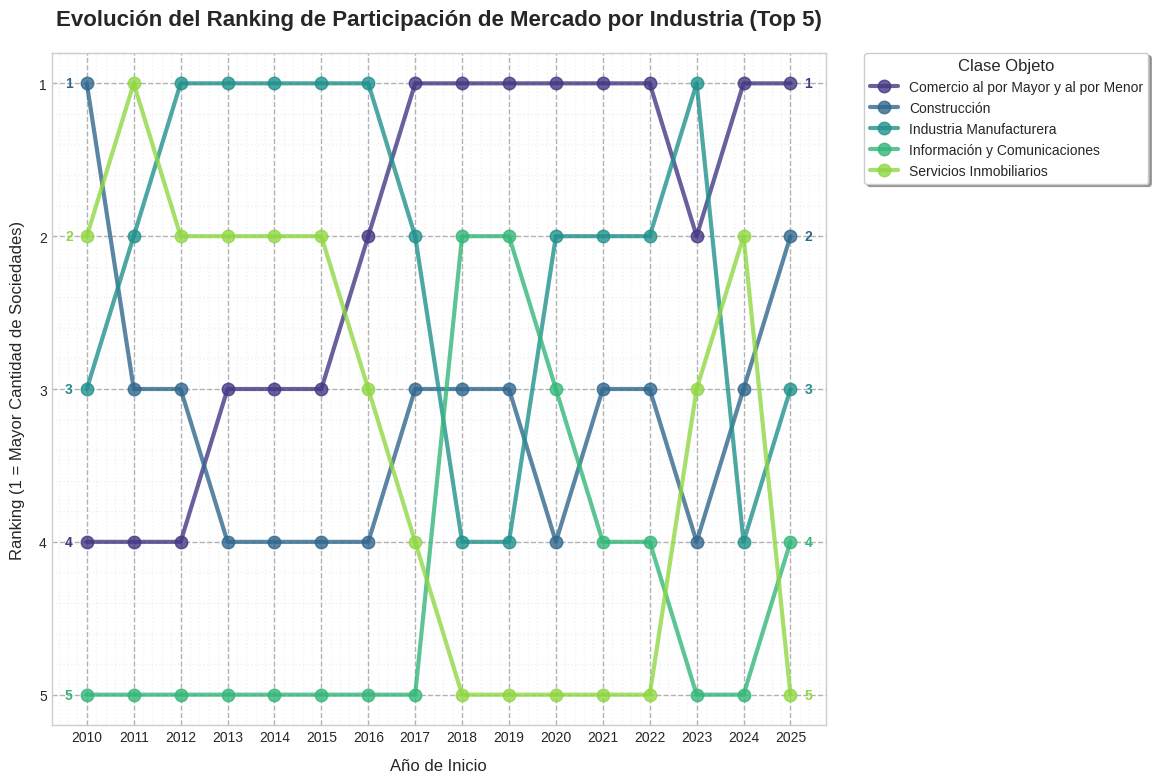

In [33]:
top_clases = df_sociedades['clase_objeto'].value_counts().head(5).index
df_top_clases = df_sociedades[df_sociedades['clase_objeto'].isin(top_clases) & (df_sociedades['anio_inicio'] >= 2010)]

counts_df = pd.crosstab(df_top_clases['anio_inicio'], df_top_clases['clase_objeto'])
rank_df = counts_df.rank(axis=1, method='first', ascending=False)


# --- Plotting Enhancements ---
plt.style.use('seaborn-v0_8-whitegrid') # A clean, modern style
plt.figure(figsize=(14, 8)) # Slightly larger figure for better readability

# Define a more vibrant color palette
palette = sns.color_palette("viridis", n_colors=len(rank_df.columns))

# Plot each line with enhanced styling
for i, column in enumerate(rank_df.columns):
    # Plot the line
    plt.plot(rank_df.index, rank_df[column],
             marker='o', # Circle markers
             markersize=9, # Slightly larger markers
             linewidth=3, # Thicker lines
             label=column,
             color=palette[i],
             alpha=0.8) # Slight transparency for overlapping lines

    # Add text labels at the start and end of each line
    # Only label the lines if they start or end within the visible x-range
    if rank_df.index.min() in rank_df.index: # Check if start year is in index
        plt.text(rank_df.index.min() - 0.3, rank_df[column].iloc[0],
                 f"{int(rank_df[column].iloc[0])}",
                 horizontalalignment='right', verticalalignment='center',
                 fontsize=10, color=palette[i], weight='bold')

    if rank_df.index.max() in rank_df.index: # Check if end year is in index
        plt.text(rank_df.index.max() + 0.3, rank_df[column].iloc[-1],
                 f"{int(rank_df[column].iloc[-1])}",
                 horizontalalignment='left', verticalalignment='center',
                 fontsize=10, color=palette[i], weight='bold')


plt.title('Evolución del Ranking de Participación de Mercado por Industria (Top 5)', fontsize=16, pad=20, weight='bold')
plt.ylabel('Ranking (1 = Mayor Cantidad de Sociedades)', fontsize=12, labelpad=10)
plt.xlabel('Año de Inicio', fontsize=12, labelpad=10)

plt.gca().invert_yaxis() # Invert Y axis so Rank 1 is at the top

# Set y-ticks to show only integer ranks (1 to 5)
plt.yticks(range(1, 6), fontsize=10)
plt.xticks(rank_df.index, fontsize=10) # Ensure all years are shown as x-ticks

# Customize grid: thinner, lighter grid lines
plt.grid(True, linestyle='--', alpha=0.6, which='major', color='grey')
plt.grid(True, linestyle=':', alpha=0.3, which='minor', color='lightgrey')
plt.minorticks_on()


# Move legend outside the plot for better space utilization
plt.legend(title='Clase Objeto', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=10, title_fontsize=12, frameon=True, shadow=True)

plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to prevent legend overlap
plt.show()

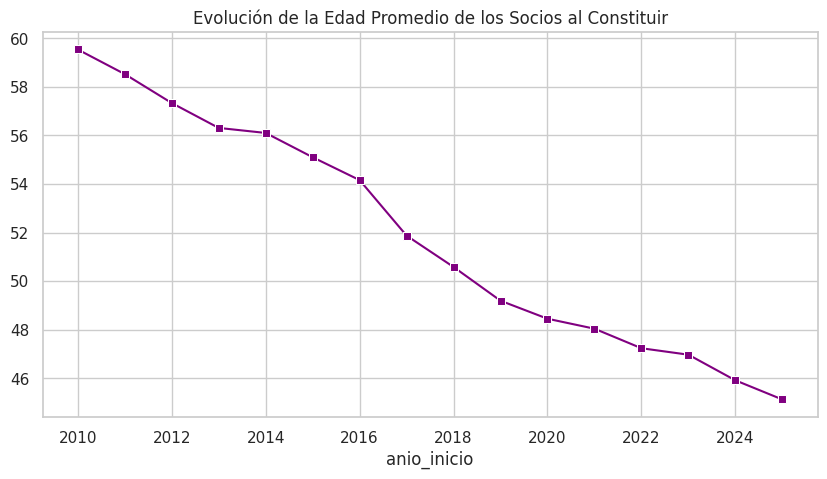

/tmp/ipykernel_4209/3967326974.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=extranjeros_ev.index, y=extranjeros_ev.values, palette="Blues")


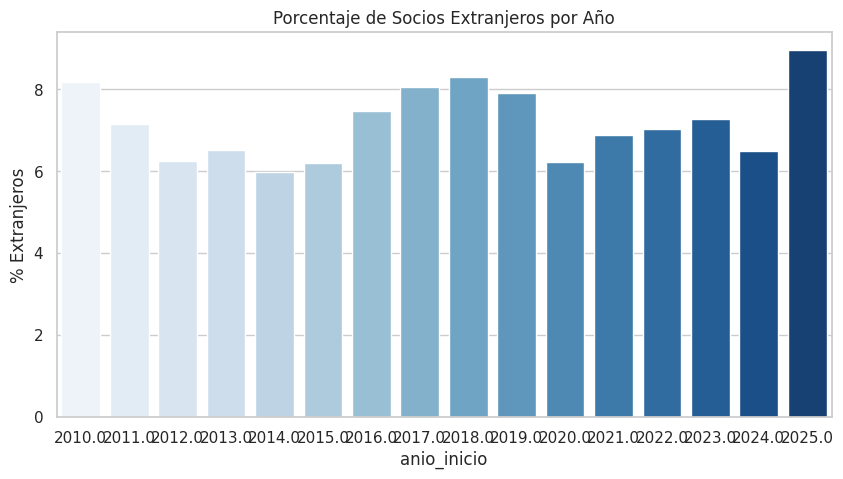

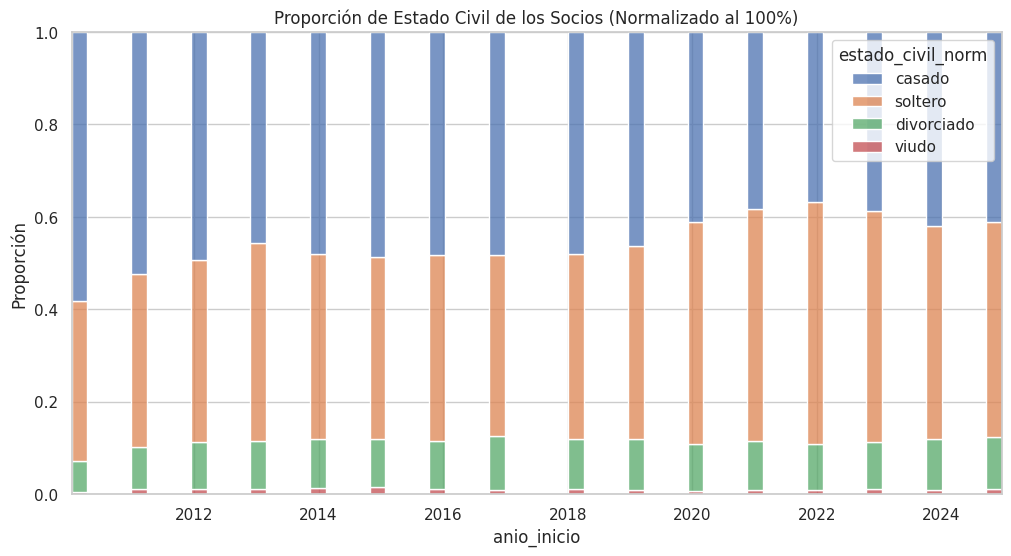

In [18]:
# Pre-procesamiento: Unir sociedades con socios
df_merged = df_socios.merge(df_sociedades[['id', 'anio_inicio']], left_on='sociedad_id', right_on='id')
df_merged = df_merged[df_merged['anio_inicio'] >= 2010]

# --- GRÁFICO 4: Edad Promedio ---
plt.figure(figsize=(10, 5))
edad_ev = df_merged.groupby('anio_inicio')['edad_calculada'].mean()
sns.lineplot(x=edad_ev.index, y=edad_ev.values, color="purple", marker="s")
plt.title('Evolución de la Edad Promedio de los Socios al Constituir')
plt.show()

# --- GRÁFICO 5: % Extranjeros ---
df_merged['es_argentino'] = df_merged['nacionalidad'].str.lower().str.contains('argentin')
extranjeros_ev = df_merged.groupby('anio_inicio')['es_argentino'].apply(lambda x: (~x).mean() * 100)
plt.figure(figsize=(10, 5))
sns.barplot(x=extranjeros_ev.index, y=extranjeros_ev.values, palette="Blues")
plt.title('Porcentaje de Socios Extranjeros por Año')
plt.ylabel('% Extranjeros')
plt.show()

# --- GRÁFICO 6: Estado Civil ---
# Normalizamos texto básico
df_merged['estado_civil_norm'] = df_merged['estado_civil'].str.lower().str.strip()
top_civil = ['casado', 'soltero', 'divorciado', 'viudo']
df_civil = df_merged[df_merged['estado_civil_norm'].isin(top_civil)]

plt.figure(figsize=(12, 6))
sns.histplot(data=df_civil, x='anio_inicio', hue='estado_civil_norm', multiple="fill", shrink=.8)
plt.title('Proporción de Estado Civil de los Socios (Normalizado al 100%)')
plt.ylabel('Proporción')
plt.show()

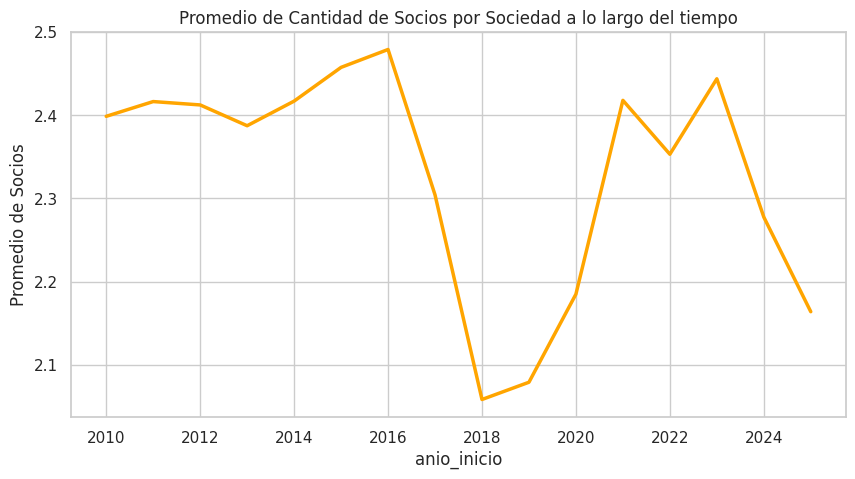

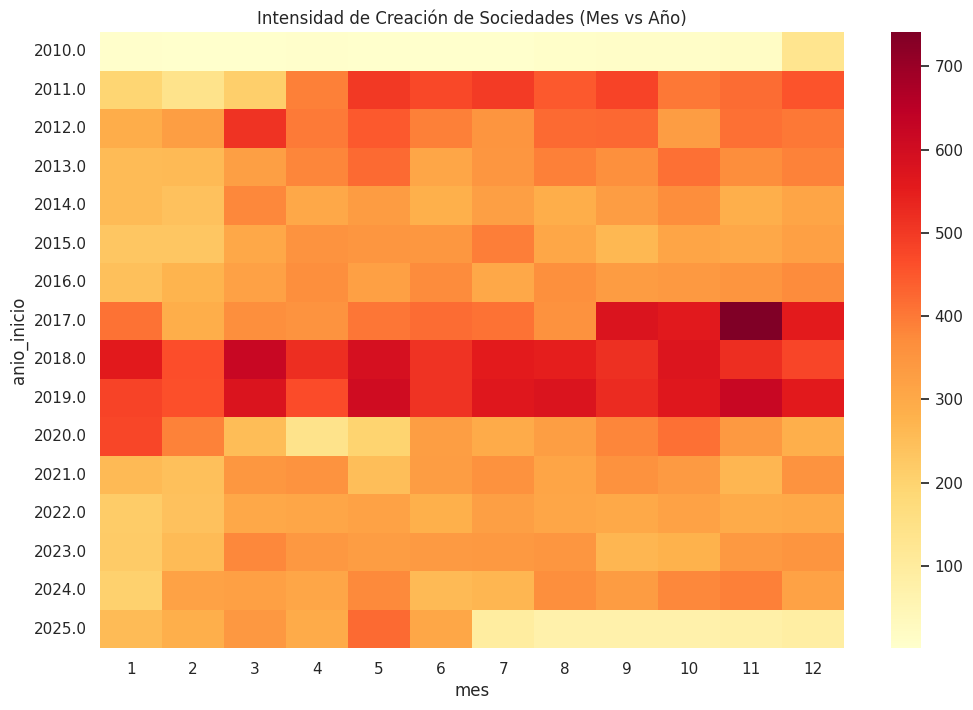

<Figure size 1200x600 with 0 Axes>

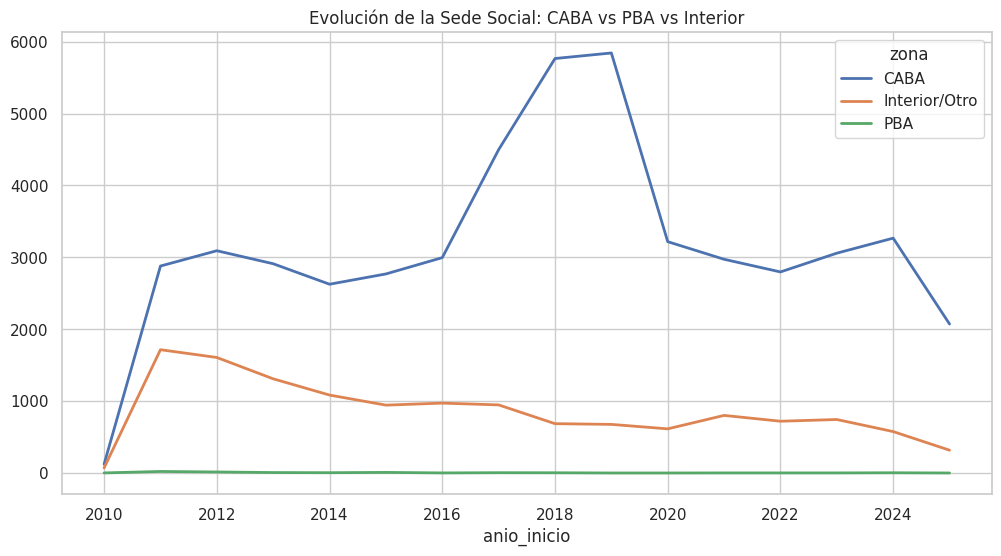

In [19]:
# --- GRÁFICO 8: Promedio de Socios por Empresa ---
socios_por_empresa = df_merged.groupby(['anio_inicio', 'sociedad_id']).size().reset_index(name='cant')
promedio_socios = socios_por_empresa.groupby('anio_inicio')['cant'].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=promedio_socios.index, y=promedio_socios.values, color="orange", linewidth=2.5)
plt.title('Promedio de Cantidad de Socios por Sociedad a lo largo del tiempo')
plt.ylabel('Promedio de Socios')
plt.show()

# --- GRÁFICO 9: Heatmap Estacional ---
df_sociedades['mes'] = df_sociedades['fecha_inicio'].dt.month
pivot_mes = df_sociedades[df_sociedades['anio_inicio'] >= 2010].pivot_table(
    index='anio_inicio', columns='mes', values='id', aggfunc='count'
)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_mes, cmap="YlOrRd", annot=False)
plt.title('Intensidad de Creación de Sociedades (Mes vs Año)')
plt.show()

# --- GRÁFICO 10: CABA vs PBA (Heurística simple) ---
def clasificar_zona(dir):
    dir = str(dir).lower()
    if 'cap. fed.' in dir or 'caba' in dir or 'ciudad autonoma' in dir: return 'CABA'
    if 'pcia' in dir or 'provincia' in dir or 'bs. as.' in dir: return 'PBA'
    return 'Interior/Otro'

df_sociedades['zona'] = df_sociedades['sede_social'].apply(clasificar_zona)
plt.figure(figsize=(12, 6))
pd.crosstab(df_sociedades['anio_inicio'], df_sociedades['zona']).plot(kind='line', figsize=(12,6), linewidth=2)
plt.title('Evolución de la Sede Social: CABA vs PBA vs Interior')
plt.show()

/tmp/ipykernel_4209/710797390.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='capital_social', y='clase_objeto', data=df_top_rubros, palette="viridis")


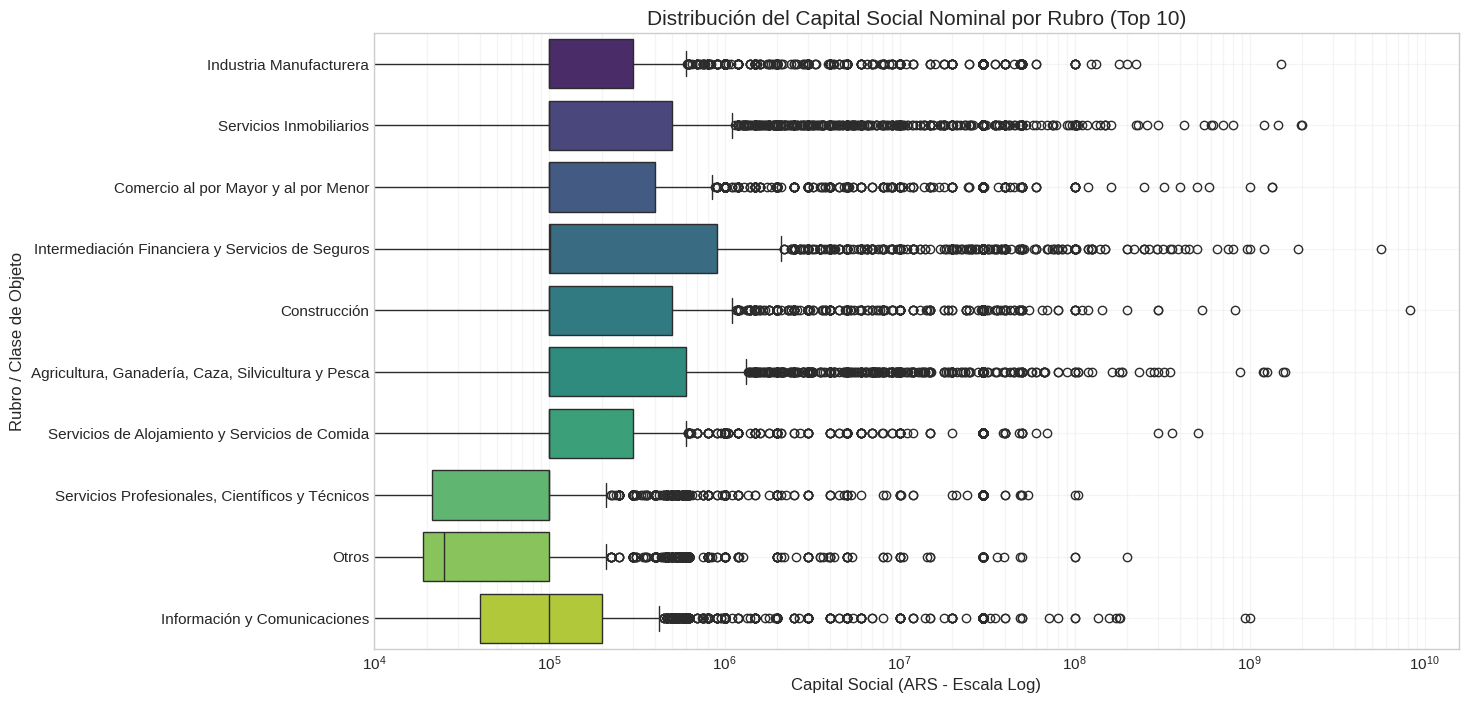

In [34]:
# 1. Identify Top 10 Rubros (Clase de Objeto)
top_rubros = df_sociedades['clase_objeto'].value_counts().head(10).index

# 2. Filter data for these rubros
df_top_rubros = df_sociedades[df_sociedades['clase_objeto'].isin(top_rubros)]

# 3. Plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='capital_social', y='clase_objeto', data=df_top_rubros, palette="viridis")

# Use log scale for better visualization of disparities
plt.xscale('log')

plt.title('Distribución del Capital Social Nominal por Rubro (Top 10)', fontsize=15)
plt.xlabel('Capital Social (ARS - Escala Log)', fontsize=12)
plt.ylabel('Rubro / Clase de Objeto', fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

In [36]:
import yfinance as yf

# 1. Fetch Historical USD/ARS Data (Official Rate)
# We download data starting from the earliest date in your analysis
print("Descargando datos históricos del tipo de cambio...")
usd_data = yf.download("ARS=X", start="2010-01-01", end=pd.Timestamp.now().strftime('%Y-%m-%d'))

# 2. Prepare Exchange Rate DataFrame
# Reset index to make Date a column and ensure it matches df_sociedades format
usd_rates = usd_data['Close'].reset_index()
usd_rates.columns = ['fecha', 'tipo_cambio']
usd_rates['fecha'] = pd.to_datetime(usd_rates['fecha']).dt.date

# 3. Prepare df_sociedades for Merge
# Ensure fecha_inicio is datetime and create a date-only column for merging
df_sociedades['fecha_inicio'] = pd.to_datetime(df_sociedades['fecha_inicio'], errors='coerce')
df_sociedades['fecha_merge'] = df_sociedades['fecha_inicio'].dt.date

# 4. Merge and Calculate
df_sociedades_usd = df_sociedades.merge(usd_rates, left_on='fecha_merge', right_on='fecha', how='left')

# Fill missing rates (weekends/holidays) with the previous valid value (Forward Fill)
df_sociedades_usd.sort_values('fecha_merge', inplace=True)
df_sociedades_usd['tipo_cambio'] = df_sociedades_usd['tipo_cambio'].ffill()

# Calculate Capital in USD
df_sociedades_usd['capital_usd'] = df_sociedades_usd['capital_social'] / df_sociedades_usd['tipo_cambio']

print("Conversión completada. Columnas agregadas: 'tipo_cambio', 'capital_usd'")
print(df_sociedades_usd[['fecha_inicio', 'capital_social', 'tipo_cambio', 'capital_usd']].head())

Descargando datos históricos del tipo de cambio...


/tmp/ipykernel_4209/1059210343.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  usd_data = yf.download("ARS=X", start="2010-01-01", end=pd.Timestamp.now().strftime('%Y-%m-%d'))
[*********************100%***********************]  1 of 1 completed

Conversión completada. Columnas agregadas: 'tipo_cambio', 'capital_usd'
     fecha_inicio  capital_social  tipo_cambio   capital_usd
755    2010-01-09         12000.0          NaN           NaN
2207   2010-01-10         12000.0          NaN           NaN
2208   2010-01-10         12000.0          NaN           NaN
3583   2010-01-11         20000.0       3.7975   5266.622924
354    2010-02-08         50000.0       3.8514  12982.292496


/tmp/ipykernel_4209/3796606392.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='capital_usd', y='clase_objeto', data=df_top_rubros_usd, palette="magma")


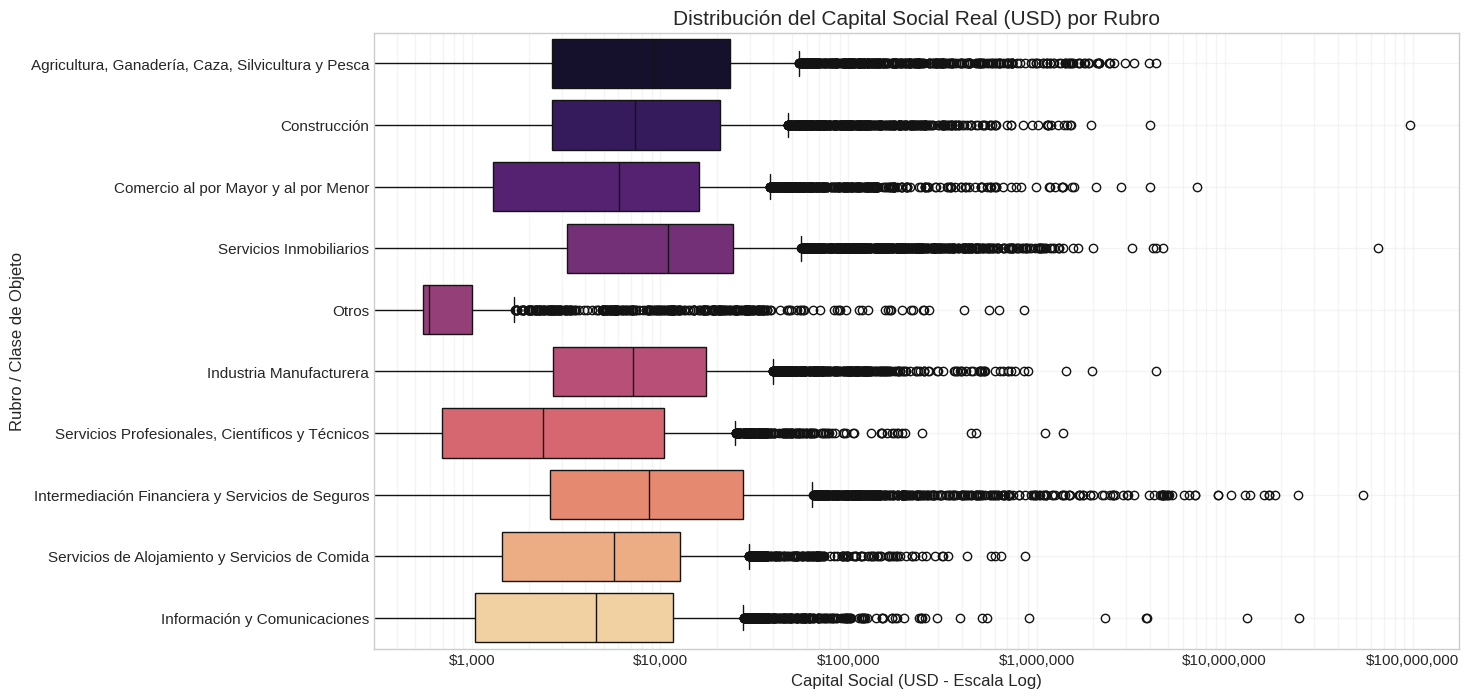

Mediana de Capital (USD) por Rubro:
clase_objeto
Servicios Inmobiliarios                               10962.508534
Agricultura, Ganadería, Caza, Silvicultura y Pesca     9324.009073
Intermediación Financiera y Servicios de Seguros       8721.110790
Construcción                                           7394.119544
Industria Manufacturera                                7142.346769
Comercio al por Mayor y al por Menor                   6065.016662
Servicios de Alojamiento y Servicios de Comida         5667.006716
Información y Comunicaciones                           4536.073064
Servicios Profesionales, Científicos y Técnicos        2371.343707
Otros                                                   593.007245
Name: capital_usd, dtype: float64


In [ ]:
# 1. Filter for Top 10 Rubros again using the new dataframe
df_top_rubros_usd = df_sociedades_usd[df_sociedades_usd['clase_objeto'].isin(top_rubros)]

# 2. Plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='capital_usd', y='clase_objeto', data=df_top_rubros_usd, palette="magma")

plt.xscale('log') # Log scale is still useful for USD due to large range of company sizes

# Formatting for currency
import matplotlib.ticker as ticker
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '${:,.0f}'.format(x)))

plt.title('Distribución del Capital Social Real (USD) por Rubro', fontsize=15)
plt.xlabel('Capital Social (USD - Escala Log)', fontsize=12)
plt.ylabel('Rubro / Clase de Objeto', fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.show()

# 3. Descriptive Statistics to verify
print("Mediana de Capital (USD) # 1. Filter for Top 10 Rubros again using the new dataframe
df_top_rubros_usd = df_sociedades_usd[df_sociedades_usd['clase_objeto'].isin(top_rubros)]

# 2. Plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='capital_usd', y='clase_objeto', data=df_top_rubros_usd, palette="magma")

plt.xscale('log') # Log scale is still useful for USD due to large range of company sizes

# Formatting for currency
import matplotlib.ticker as ticker
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '${:,.0f}'.format(x)))

plt.title('Distribución del Capital Social Real (USD) por Rubro', fontsize=15)
plt.xlabel('Capital Social (USD - Escala Log)', fontsize=12)
plt.ylabel('Rubro / Clase de Objeto', fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.show()

# 3. Descriptive Statistics to verify
print("Mediana de Capital (USD) por Rubro:")
print(df_top_rubros_usd.groupby('clase_objeto')['capital_usd'].median().sort_values(ascending=False))por Rubro:")
print(df_top_rubros_usd.groupby('clase_objeto')['capital_usd'].median().sort_values(ascending=False))

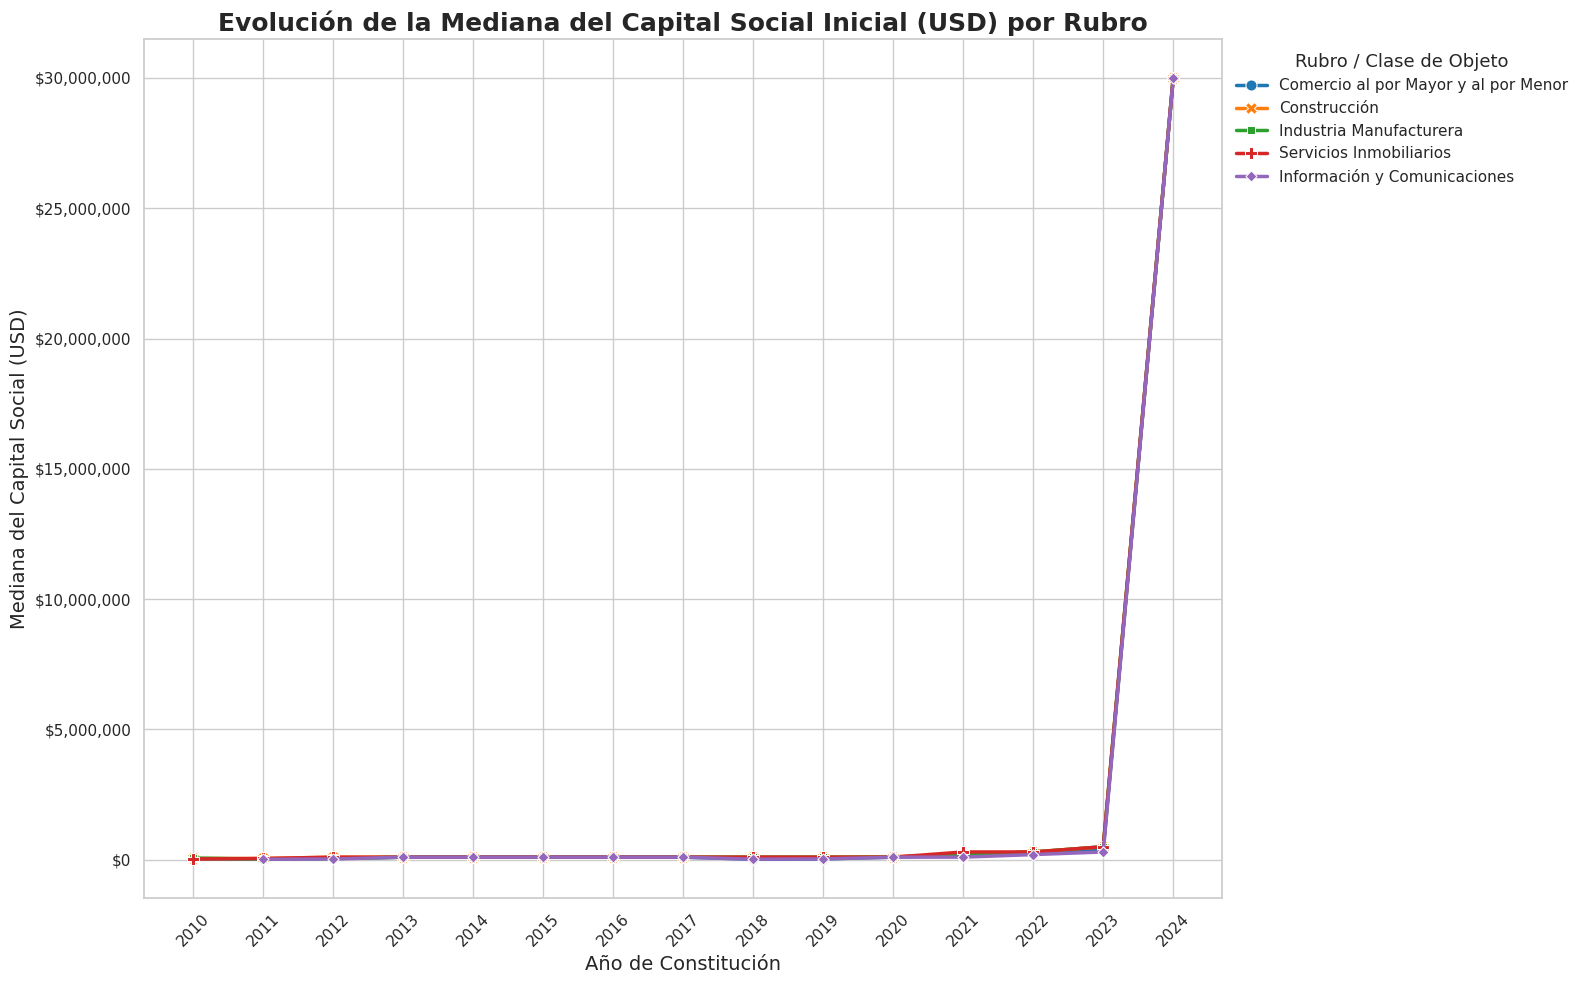

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker

# 1. Filtrar los Top 10 Rubros (si no lo has hecho ya)
# Usamos value_counts para encontrar los más frecuentes
top_rubros = df_sociedades_usd['clase_objeto'].value_counts().head(5).index
df_top_10 = df_sociedades_usd[df_sociedades_usd['clase_objeto'].isin(top_rubros)].copy()

# 2. Agrupar por Año y Rubro
# Calculamos la mediana del capital en USD para cada grupo
df_evolution = df_top_10.groupby(['anio_inicio', 'clase_objeto'])['capital_social'].median().reset_index()

# Filtramos años irrelevantes si es necesario (ej. errores de fecha < 2010 o futuros)
df_evolution = df_evolution[(df_evolution['anio_inicio'] >= 2010) & (df_evolution['anio_inicio'] <= 2024)]

# 3. Configurar el Gráfico
plt.figure(figsize=(16, 10))
sns.set_theme(style="whitegrid")

# Crear el line chart
line_plot = sns.lineplot(
    data=df_evolution,
    x='anio_inicio',
    y='capital_social',
    hue='clase_objeto',
    style='clase_objeto',   # Diferentes estilos de línea para ayudar a distinguir
    markers=True,           # Poner puntos en cada año
    dashes=False,           # Líneas sólidas
    palette="tab10",        # Paleta de colores distintiva
    linewidth=2.5,
    markersize=8
)

# 4. Formato y Estilo
plt.title('Evolución de la Mediana del Capital Social Inicial (USD) por Rubro', fontsize=18, weight='bold')
plt.xlabel('Año de Constitución', fontsize=14)
plt.ylabel('Mediana del Capital Social (USD)', fontsize=14)

# Formato de moneda en el eje Y (ej: $5,000)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '${:,.0f}'.format(x)))

# Escala Logarítmica (Opcional: Descomentar si las diferencias son muy extremas)
# plt.yscale('log') 

# Ajustar la leyenda
plt.legend(title='Rubro / Clase de Objeto', title_fontsize='13', fontsize='11', loc='upper left', bbox_to_anchor=(1, 1))

# Ajustar límites del eje X para que se vean todos los años enteros
plt.xticks(df_evolution['anio_inicio'].unique(), rotation=45)

plt.tight_layout()
plt.show()